# Geospatial Data Processing with PyGdal & Folium

## Introduction
In this tutorial, we would explore how to do Geospatial Data Processing and visualizing the result. Most Geospatial processing demonstrations uses hack such as assuming the world is flat while performing calculation. We would do it the "professional way" by using the specialized geospatial data processing libaries, GDAL. Results would then be visualize over an interactive map using Folium. Geospatial Data inherent lives on the maps and this is a richer form of visualization than 2D histograms or line plots. To achieve all this requires a good understanding of coordinate reference systems, GIS dataset and the use of efficient libraries.


## Working with GIS Data

### Vector and Raster

**Geographical Information System (GIS)** data comes in two major model; raster and vector. Raster data is a representation of the world as a surface divided into a regular grid of cells. Raster models are useful for storing data that varies continuously, as in an aerial photograph, satellite imagery, an elevation surfaces and density maps. Vector data on the other hand, is a representation of the world using points, lines, and polygons. Vector models are useful for storing data that has discrete boundaries, such as country borders, land parcels, and streets. 

<img src="images/vector_vs_raster.gif" />

In order to be able to overlay different GIS information, be it vector or raster, a common point of reference is needed. In the GIS world, this common reference is known as a Coordinate Referencing System.

### Coordinate Referencing System (CRS)
A spatial reference system (SRS) or **Coordinate Reference System (CRS)** is a coordinate-based local, regional or global system used to locate geographical entities. A spatial reference system defines a specific map projection, as well as transformations between different spatial reference systems. This provides a common reference to the coordinates in GIS data

European Petroleum Survey Group (EPSG) publishes CRS information as well as map projection and datum. The oil and gas industry requires very accurate coordinates for their exploration and drilling operations. Thus alot of effort has been spent into surveying and ensuring the quality of the CRS. The EPSG is the standard for most GIS data. 

The common Latitude-Longtiude CRS has a EPSG code of EPSG:4326.It is more commonly known as the _World Geodetic System, WGS84_ and used by the GPS network. While the WGS84 standard is ubiquitous, latitude and longtitude are measured in angles and unless you are from the maritime industry or astronomy, most people are more familiar in reasoning distances in meters or feets. The reason for this difference is that the Earth is not flat but rather, an ellipsoid. Meters and feets are meant for measuring distance on a flat surface. Thus for a coordinate system to work throughout the world, it has to account for the curvature of the Earth, making measurements in angle more sensible. Most GIS tools such as Google Earth, OpenStreetMap and folium use the WGS84 CRS by default since it is the same regardless of your location in the world.

<img src="images/latlon.png" style="max-width:100%; width: 70%"/>

The **Universal Transverse Mercator (UTM)** map projection, like WGS84 uses a 2-dimensional Cartesian coordinate system to give locations on the surface of the Earth. Like the traditional method of latitude and longitude, it is a horizontal position representation, i.e. it is used to identify locations on the Earth independently of vertical position. However, the UTM system is not a single map projection. The system instead divides the Earth into sixty zones, each being a six-degree band of longitude, and uses a secant transverse Mercator projection in each zone. Each UTM region is approximated with a flat surface and a uniform grid. However there are exceptions to the scheme are certain location in the world.

UTM is a convenient coordinate system as 1 unit is 1 meter.

<img src="images/Utm-zones-USA.svg.png" style="max-width:100%; width: 60%"/>




### Shapefile (.shp)

The shapefile format is a popular vector storage format for storing both geometric location and associated attribute information, similar to a database. The shapefile format is simple because it can store the primitive geometric data types of points, lines, and polygons. Shapes (points/lines/polygons) together with data attributes can create many representations about geographic data. Representation provides the ability for powerful and accurate computations.

It is important to note that the _shapefile_ is collection of different files sharing the same filename.
The following are mandatory for opening any shapefile. 
1. .shp — shape format; the feature geometry itself
2. .shx — shape index format; a positional index of the feature geometry to allow seeking forwards and backwards quickly
3. .dbf — attribute format; columnar attributes for each shape, in dBase IV format

An additional but optional, _.prj_ file contains the CRS and projection information which is useful to allow software to automatically inferred the CRS.

### Well Known Text (WKT) format 
**Well-known text (WKT)** is a text markup language for representing vector geometry objects on a map, spatial reference systems of spatial objects and transformations between spatial reference systems. WKT can represent 18 distinct geometric objects. The WKT format is a richer vector format which can be used to plot the analytics results for visualization.

## Getting Started with PyGDAL and Folium
Geospatial Data Abstraction Library (GDAL/OGR) is a cross platform GIS library for raster and vector. It presents a single abstract data model for all supported formats and it supports over 50 raster formats, and OGR over 20 vector formats. It has many powerful tools and workflows such as panchromatic image sharpening or vector manipulation which are essential for the GIS specialist. 

PyGDAL is the python bindings for GDAL.

<img src="images/150px-GDALLogoColor.svg.png" />

**Folium** is a great *interactive* geospatial visualization python library. Folium builds on the data wrangling strengths of the Python ecosystem and the mapping strengths of the Leaflet.js library. The library has a number of built-in tilesets such as OpenStreetMap.

Folium rides on top of Leaflet.js. Maps are output to html files which are then render using the web browser. This takes advantage of the browser better rendering capabilities and ability to stream map tiles from online server as compared to Python rendering capabilities. For traditional Python applications, this would be toggling between the python program and the web browser when using Folium. Fortunately with, IPython and Jupyter, webpages can be rendered directly inline within the Jupyter notebooks, thus streamlining the process.

## Code Example in PyGDAL and Folium

For this example, we would be processing Port Authority of Pittsburgh bus TrueTime data. The bus data can be obtained at (http://truetime.portauthority.org/bustime/home.jsp) and it consist of individual bus information, route information and time stamped GPS traces. We would analyse the spatial coverage of this sample of bus data on the pittsburgh neighborhood.


In [1]:
#import the relevant OSgeo library
from osgeo import gdal
from osgeo import ogr
from osgeo import osr
#import database libraries, pandas, geopandas, folium
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import folium
#useful tools
from IPython.display import HTML
import shapely
from shapely.geometry import Point
import shapely.wkt
import numpy as np
import scipy as sp
import scipy.ndimage
import matplotlib.pyplot as plt
import sys
%matplotlib inline

We would first load the data which is in a CSV file and convert it to a GeoPandas Dataframe. Notice the GPS locations are stored in the WKT format. While this is optional, it is preferred that point locations are to be stored in WKT format as we would be using other geometry such as polygons in this example.

In [12]:
#loading a series of points in latlon
trips = pd.read_csv('trips.csv') 
trips['WGS84'] = trips.apply(lambda z: Point(z.lon, z.lat), axis=1) #WKTPoint(X,Y)
trips['tmstmp'] = trips['tmstmp'].apply(pd.to_datetime)
trips = gpd.GeoDataFrame(trips)
trips.crs = {'init': 'epsg:4326', 'no_defs': True}
trips.head()

,vid,lat,lon,rt,tmstmp,WGS84
0,5549,40.439504,-79.996981,61A,2016-08-11 10:56:00,POINT (-79.9969810037 40.4395040624)
1,5287,40.438016,-79.927380,61A,2016-08-11 10:56:00,POINT (-79.9273800517 40.4380164036)
2,6114,40.418897,-79.883970,61A,2016-08-11 10:56:00,POINT (-79.88396966649999 40.4188965969)
3,5646,40.441155,-79.892990,61A,2016-08-11 10:56:00,POINT (-79.8929902229 40.4411547011)
4,5443,40.436370,-79.968362,61A,2016-08-11 10:56:00,POINT (-79.9683620106 40.4363703641)


The matplotlib package is able to interpret the WKT format directly as a point in a 2D plane and plot it. However this is not good practice as matplotlib is not optimized to render large amounts of datapoint and this can be very slow to plot.

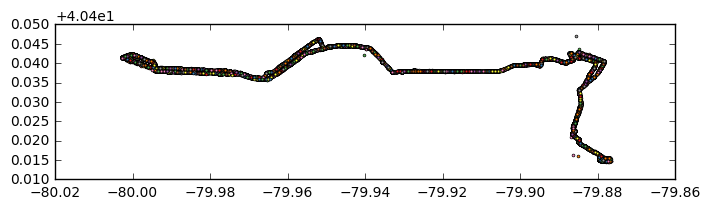

In [20]:
trips[trips['rt']=='61A']['WGS84'].plot(figsize=(8,8)) #might take awhile

When we are working with large datasets, it is sometime useful to look at aggregated data. A 2D histogram of the locations gives the overview of the densities of the buses locations. In the GIS context, such a 2D histogram plot is called a heatmap and often it is represented as a **raster** as it is approximately continuous with respect to physical coordinates. For this example, we would be using numpy histogram 2D and scipy ndimage smoothing to make the 2D histogram. The smoothing is to make the heatmap look less pixelated. While this might not give an extremely precise representation of the data, it is sufficient for high level view of the data. Again we would use matplotlib to render the heatmap.

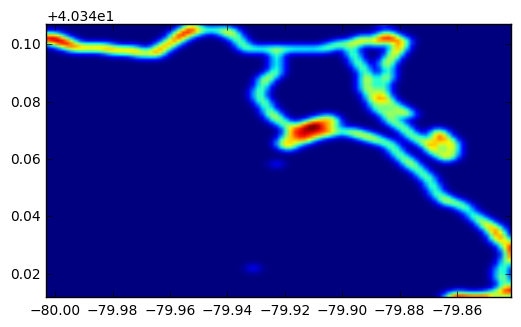

In [43]:
def heatmap(coord, bins=(100,100), smoothing=1.3, cmap='jet'):
    heatmap, xedges, yedges = np.histogram2d(coord[1], coord[0], bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]
    heatmap = np.maximum(heatmap,1e-15)
    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = sp.ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.gca().invert_yaxis()
    plt.show()

coord = (list(trips.lon),list(trips.lat))
heatmap(coord)

Now, we would transform the GPS location from WGS84 (EPSG4326) to UTM (EPSG32617) so that we can calculate distances in meters. To do we first set up a coordinate transformer before applying to the each of the WKT point.

In [3]:
source = osr.SpatialReference()
source.ImportFromEPSG(4326)

target = osr.SpatialReference()
target.ImportFromEPSG(32617) # Pittsburgh is zone 17N

transform = osr.CoordinateTransformation(source, target)
utm = []
for loc in trips['WGS84']:
    geom = ogr.CreateGeometryFromWkt(str(loc))
    geom.Transform(transform)
    utm.append(shapely.wkt.loads(geom.ExportToWkt()))
trips['UTM'] = utm
trips.head()

,vid,lat,lon,rt,tmstmp,WGS84,UTM
0,5549,40.439504,-79.996981,61A,2016-08-11 10:56:00,POINT (-79.9969810037 40.4395040624),POINT (585066.6632140249 4477022.727614116)
1,5287,40.438016,-79.927380,61A,2016-08-11 10:56:00,POINT (-79.9273800517 40.4380164036),POINT (590971.6757748827 4476926.957744638)
2,6114,40.418897,-79.883970,61A,2016-08-11 10:56:00,POINT (-79.88396966649999 40.4188965969),POINT (594680.3084741266 4474850.241477243)
3,5646,40.441155,-79.892990,61A,2016-08-11 10:56:00,POINT (-79.8929902229 40.4411547011),POINT (593884.0573293241 4477311.304526103)
4,5443,40.436370,-79.968362,61A,2016-08-11 10:56:00,POINT (-79.9683620106 40.4363703641),POINT (587497.9621894992 4476702.840124533)


GeoPandas offer a convenient way to convert coordinate system. First have a column name "geometry" and have the objects stored in WKT format. Next set the initial crs of the GeoDataFrame before converting using the .to_crs() function with the relevant EPSG codes. 

The downside to this approach is that it can only have 1 geometry per dataframe.

In [115]:
test_pd = trips.copy(deep=True)
test_pd['geometry'] = test_pd['WGS84']
test_pd.crs = {'init': 'epsg:4326', 'no_defs': True}
test_pd = test_pd.to_crs(epsg='32617')

In [116]:
test_pd.head()

,vid,lat,lon,rt,tmstmp,WGS84,UTM,geometry
0,5549,40.439504,-79.996981,61A,2016-08-11 10:56:00,POINT (-79.9969810037 40.4395040624),POINT (585066.6632140249 4477022.727614116),POINT (585066.6632140152 4477022.72761375)
1,5287,40.438016,-79.927380,61A,2016-08-11 10:56:00,POINT (-79.9273800517 40.4380164036),POINT (590971.6757748827 4476926.957744638),POINT (590971.6757748671 4476926.957744273)
2,6114,40.418897,-79.883970,61A,2016-08-11 10:56:00,POINT (-79.88396966649999 40.4188965969),POINT (594680.3084741266 4474850.241477243),POINT (594680.3084741083 4474850.241476877)
3,5646,40.441155,-79.892990,61A,2016-08-11 10:56:00,POINT (-79.8929902229 40.4411547011),POINT (593884.0573293241 4477311.304526103),POINT (593884.0573293056 4477311.304525735)
4,5443,40.436370,-79.968362,61A,2016-08-11 10:56:00,POINT (-79.9683620106 40.4363703641),POINT (587497.9621894992 4476702.840124533),POINT (587497.9621894876 4476702.840124165)


A quick plot of the heatmap of the coordinates in UTM shows that the bus locations looks similar but with slight stretching that makes it look like it was plotted on a uniform grid.

_Can you explain why? Hint: the CRS matters._ 

We can see that the bus coordinates are within a 12.8km by 10.5km grid.

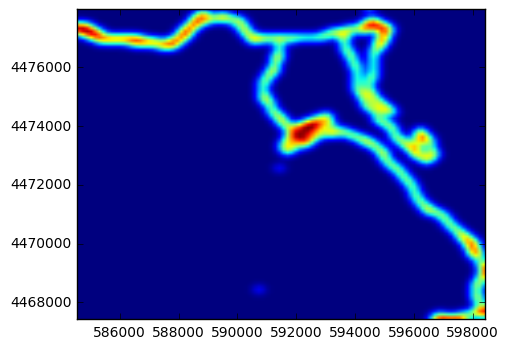

X range 13863.4651733
Y range 10539.253099


In [117]:
X = [p.x for p in trips.UTM]
Y = [p.y for p in trips.UTM]
coord = (X,Y)
heatmap(coord)
print "X range", np.amax(X)-np.amin(X)
print "Y range", np.amax(Y)-np.amin(Y)

Now, lets examine the distances of the bus rides.

In [160]:
def euclidean_distance(p1, p2):
    return np.linalg.norm([p1.x-p2.x, p1.y-p2.y])
def split_trips_and_measure(df):
    trips_distances=[]
    count = 0
    for name, group in df.groupby(['vid']):
        new_group = group.copy(deep=True)
        new_group.sort_values(['tmstmp'],inplace=True)
        loc = new_group['UTM'].values
        new_dist = 0.0
        for i in range(1, len(loc)):
            d = euclidean_distance(loc[i],loc[i-1])
            if d > 3000.0: # assumes that if the bus jumps by 3km in a minute than it is a new trip
                trips_distances.append(new_dist)  
                new_dist = 0.0
            else:
                new_dist += d
    return trips_distances

trip_distance = split_trips_and_measure(trips)

Below is a histogram of the bus trips. The longest journey is about 380km. That is a rather long ride! This works out to be a 4-6hrs trip. The mean distance of 62.6 km is about a 1 hrs bus trip.

total number of trips: 783 longest: 380463.69682 mean: 62489.0583537


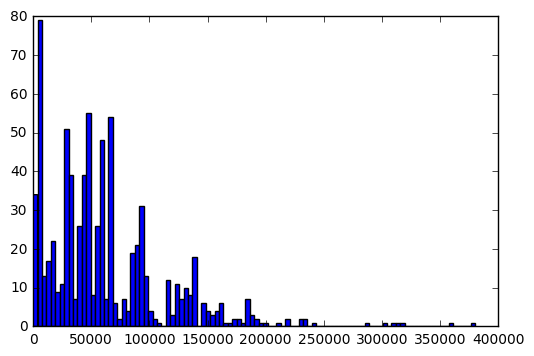

In [162]:
print "total number of trips:", len(trip_distance), "longest:", np.amax(trip_distance), "mean:", np.mean(trip_distance)
dist_hist = plt.hist(trip_distance, 100)

## Visualization of GIS data using Folium
Now that we know the buses in Pittsburgh do travel pretty long distance, the natural question would be how much area of Pittsburgh do the buses cover? From the heatmap we have generated, we can see the buses are generally clustered at Downtown area and near the universities. However this analysis is limited as the grids are uniform squares. A more interesting question would be how are the neighborhood served by the bus routes.

The Pittsburgh neighborhood vector file can be found in the Census_Data.zip file from the Pittsburgh city planning website: http://apps.pittsburghpa.gov/dcp/Census_Data.zip. It contains Neighborhood.shp file and the other files associated with it. 

_Try to see if you can identify what are the other files for._

To load the shape file, we would use Folium and OpenStreetMap as the base layer. The GeoDataFrame has to be interpreted as a GeoJSON as that is the vector format use by Folium.

In [10]:
neighborhood_gpd = gpd.GeoDataFrame.from_file('vector/Neighborhood.shp')
neighborhood_gpd = neighborhood_gpd.to_crs(epsg='4326')
neighborhood_json = neighborhood_gpd['geometry'].to_json()
pitts_map = folium.Map(location=[40.4, -79.9],width=800, height=800, zoom_start=12)
folium.GeoJson(neighborhood_json).add_to(pitts_map)
pitts_map #drawing of folium maps is support natively in IPython! 

<img src="images/neighbor.png" style="max-width:100%; width: 70%" /> 
This output of the neighborhoods should look like the above for comparison. Notice that it is interactive and is more responsive than the use matplotlib output. Also note that the CRS of the original shape files are in NAD83 which is North American Datum of 1983 and we converted it to EPSG 4326.

In [13]:
print(neighborhood_gpd.crs)
print(trips.crs)

{'init': 'epsg:4326', 'no_defs': True}
{'init': 'epsg:4326', 'no_defs': True}


In [14]:
len(trips)

215473

There are a total of ~200000 points in trips and 90 polygons in the neighborhood vector layers. It is computationally intensive to do pairwise check of points within polygon. Fortunately, geopandas and the underlying gdal libraries offer us a very efficient way of computing list of points intersection in polygon. This is a spatial join, similar to SQL's JOIN command.

In [15]:
trips['geometry'] = trips['WGS84'] # geopandas operate looks for the 'geometry' column
pointInPolys = sjoin(trips, neighborhood_gpd, how='left',op='within')
grouped = pointInPolys.groupby('index_right')

Once we have for each point, the polygon index which it belongs to, using the groupby iterator, we can efficiently tally the number of points in each neighborhood.

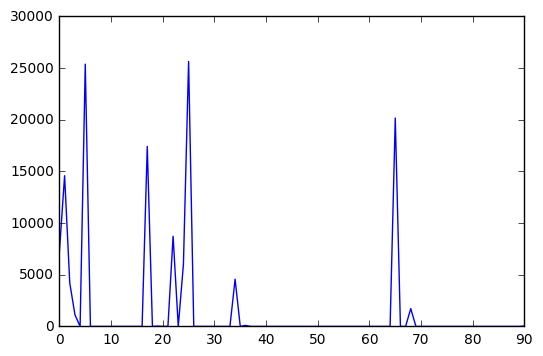

In [23]:
tally = np.zeros(len(neighborhood_gpd))
for name, group in grouped:
    tally[int(name)] = len(group)
    
neighborhood_gpd['tally'] = pd.Series(tally)
plt.plot(neighborhood_gpd['tally'])

To visualize the tally onto the map, we first create a colormap to color the neighborhood polygons. While Folium offers some colormaps, their selection is pretty limited. We would use the colormaps from matplotlib, convert it to json and pass it to Folium for rendering. Note that Folium uses hexadecimal string \#000000-\#ffffff for this color notation as this is more common in web browsers.

In [45]:
def convert_to_hex(rgba_color) :
    red = str(hex(int(rgba_color[0]*255)))[2:]
    green = str(hex(int(rgba_color[1]*255)))[2:]
    blue = str(hex(int(rgba_color[2]*255)))[2:]

    if blue=='0':
        blue = '00'
    if red=='0':
        red = '00'
    if green=='0':
        green='00'

    return '#'+ red + green + blue

norm = plt.Normalize()
colors = plt.cm.YlOrRd(norm(tally))
alpha = np.zeros(len(tally))
for i in range(len(tally)): 
    if tally[i] != 0:
        alpha[i] = 0.5 #set transparency to 0 for 0 tally
colors = [convert_to_hex(c) for c in colors]
print colors[:5]

['#fece6b', '#fc6a32', '#fee692', '#fff8bc', '#ffffcc']


In [46]:
tally_gpd = neighborhood_gpd[['geometry']].copy(deep=True)
tally_gpd['color'] = pd.Series(colors)
tally_gpd['alpha'] = pd.Series(alpha)
tally_gpd['tally'] = pd.Series(tally)
tally_json = tally_gpd.to_json()
tally_map = folium.Map(location=[40.4, -79.9],width=800, height=800, zoom_start=12)
folium.GeoJson(tally_json,
    style_function=lambda feature: {
        'fillColor': feature['properties']['color'],
        'weight' : 1,
        'fillOpacity' : feature['properties']['alpha'],
        }).add_to(tally_map)
tally_map

<img src="images/tally.png" style="max-width:100%; width: 70%" /> 
What a pretty map! 

With one glance, we can see which are the neighborhoods that are better served by this sample of bus data and visualizing the output on a interactive map is richer than 2D histograms or line plots. This is possible with a good understanding of coordinate reference systems, GIS dataset and useful and efficient libraries such as PyGDAL and Folium